## Super resolution

In [ ]:
import fastai
from fastai.vision import *
from fastai.callbacks import *

from torchvision.models import vgg16_bn

In [ ]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

In [ ]:
il = ImageItemList.from_folder(path_hr)

In [ ]:
def resize_one(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [ ]:
# to create smaller images, uncomment the next line when you run this the first time
# parallel(resize_one, il.items)

In [ ]:
bs,size=32,128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).random_split_by_pct(0.1, seed=42)

In [ ]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [ ]:
data = get_data(bs,size)

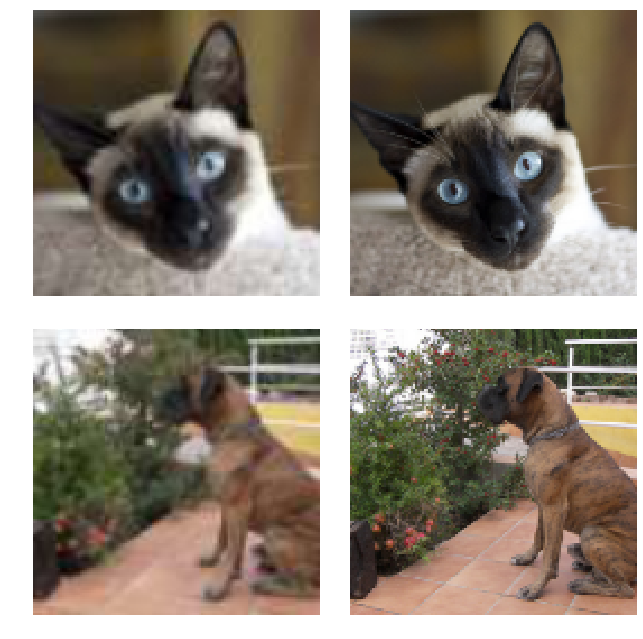

In [ ]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Feature loss

In [ ]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [ ]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [ ]:
gram_matrix(t)

tensor([[[0.0759, 0.0711, 0.0643],
         [0.0711, 0.0672, 0.0614],
         [0.0643, 0.0614, 0.0573]],

        [[0.0759, 0.0711, 0.0643],
         [0.0711, 0.0672, 0.0614],
         [0.0643, 0.0614, 0.0573]]])

In [ ]:
base_loss = F.l1_loss

In [ ]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [ ]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [ ]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [ ]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [ ]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


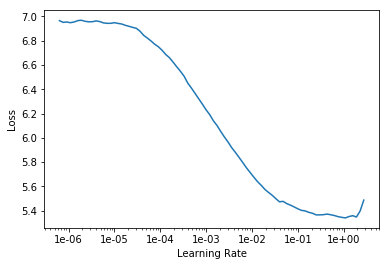

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-3

In [ ]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,4.008404,3.886769,0.163337,0.237086,0.322779,0.230760,0.583623,1.240286,1.108898
2,3.844956,3.833568,0.223097,0.233521,0.315911,0.222365,0.565570,1.208495,1.064610
3,3.738669,3.650235,0.159902,0.231294,0.307983,0.213696,0.533869,1.177080,1.026411
4,3.676721,3.555500,0.178817,0.228709,0.300611,0.206124,0.512305,1.137304,0.991630
5,3.644221,3.513477,0.169150,0.224580,0.296139,0.206002,0.507610,1.115546,0.994450
6,3.605411,3.441517,0.166812,0.225828,0.294018,0.200452,0.493995,1.099098,0.961314
7,3.588461,3.404402,0.166617,0.225738,0.293541,0.199285,0.472539,1.088028,0.958656
8,3.540644,3.410634,0.161137,0.225195,0.292901,0.198377,0.481368,1.097983,0.953671
9,3.535214,3.358761,0.166424,0.219094,0.286857,0.196493,0.467032,1.073146,0.949715
10,3.386384,3.197031,0.147175,0.216842,0.278016,0.188442,0.436787,1.022630,0.907139


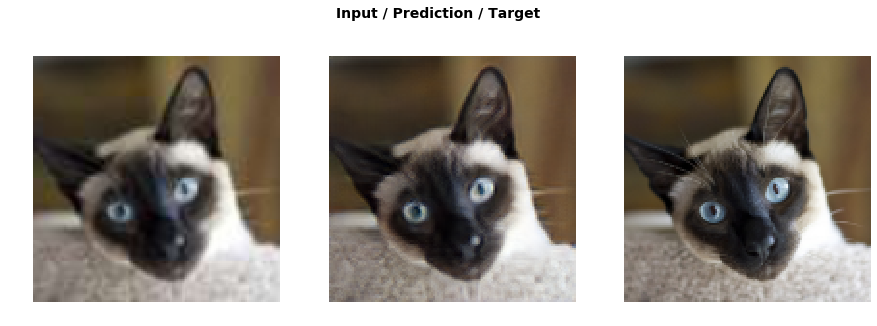

In [ ]:
do_fit('1a', slice(lr*10))

In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,3.372949,3.178720,0.141911,0.216299,0.277225,0.187835,0.433569,1.017344,0.904537
2,3.354379,3.171785,0.145001,0.216376,0.277003,0.187376,0.429996,1.013523,0.902511
3,3.364273,3.174867,0.144587,0.216066,0.276888,0.187590,0.429583,1.016179,0.903974
4,3.362229,3.158420,0.141403,0.215463,0.275896,0.186404,0.429139,1.011496,0.898618
5,3.352682,3.152699,0.142209,0.215341,0.275683,0.186036,0.427523,1.008963,0.896945
6,3.353071,3.155885,0.143842,0.215298,0.275151,0.185610,0.431838,1.009978,0.894167
7,3.320625,3.145141,0.144024,0.214828,0.275036,0.185680,0.424494,1.006634,0.894445
8,3.321828,3.151162,0.142985,0.214913,0.275038,0.185738,0.428227,1.010272,0.893990
9,3.340473,3.135104,0.140836,0.214723,0.274523,0.184649,0.425235,1.005936,0.889203
10,3.321849,3.126194,0.147991,0.214160,0.273085,0.183970,0.421198,0.999574,0.886215


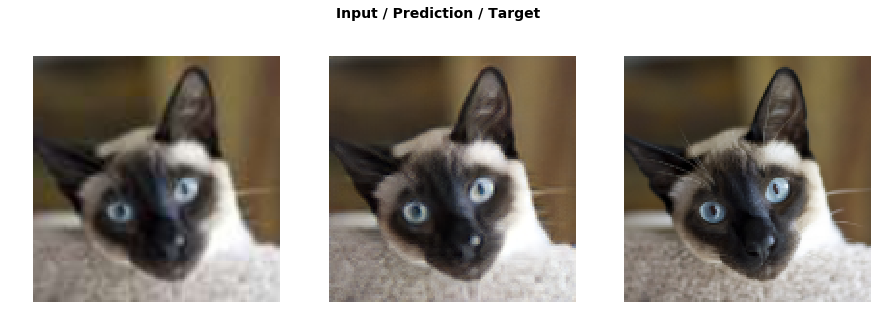

In [ ]:
do_fit('1b', slice(1e-5,1e-3))

In [ ]:
data = get_data(bs//2,size*2)
learn.data = data
learn.freeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,2.314849,2.223613,0.170180,0.260200,0.292809,0.153386,0.394207,0.581963,0.370867
2,2.270622,2.184419,0.170135,0.260769,0.292438,0.152400,0.372992,0.569718,0.365968
3,2.253721,2.175571,0.176805,0.261460,0.290702,0.150485,0.368293,0.566592,0.361233
4,2.235269,2.151876,0.175470,0.260996,0.289085,0.149456,0.358147,0.560373,0.358350
5,2.211186,2.137626,0.174294,0.260152,0.288278,0.149201,0.352134,0.556635,0.356932
6,2.207417,2.118825,0.172858,0.260517,0.287378,0.148614,0.343222,0.550978,0.355257
7,2.198069,2.107547,0.174045,0.258458,0.284167,0.146776,0.345125,0.547418,0.351556
8,2.188601,2.131358,0.195787,0.258661,0.284722,0.147256,0.341497,0.551266,0.352170
9,2.164028,2.101818,0.175016,0.257835,0.282435,0.145483,0.344756,0.546625,0.349669
10,2.143203,2.073432,0.170792,0.257662,0.281873,0.145103,0.330559,0.540407,0.347036


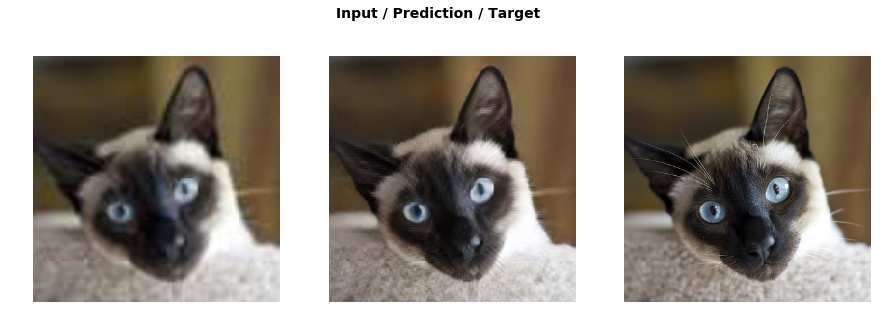

In [ ]:
do_fit('2a')

In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,2.144731,2.075333,0.172685,0.257902,0.282146,0.145164,0.330336,0.539963,0.347137
2,2.145790,2.074806,0.172007,0.257407,0.281614,0.145158,0.330995,0.540517,0.347110
3,2.141171,2.069635,0.171121,0.257899,0.281966,0.144866,0.328259,0.538941,0.346583
4,2.115627,2.068765,0.171525,0.257369,0.281603,0.144958,0.328752,0.537845,0.346714
5,2.117494,2.066716,0.171011,0.257064,0.281119,0.144829,0.329027,0.537297,0.346369
6,2.123163,2.067055,0.172411,0.257504,0.280971,0.144660,0.328904,0.536460,0.346145
7,2.130089,2.080163,0.182159,0.257323,0.281463,0.144893,0.328682,0.539059,0.346585
8,2.128453,2.066560,0.171783,0.257658,0.281195,0.144701,0.328064,0.537137,0.346021
9,2.123921,2.080847,0.187461,0.257420,0.281031,0.144591,0.328390,0.536148,0.345806
10,2.126108,2.070255,0.176738,0.257470,0.280978,0.144573,0.328599,0.535826,0.346071


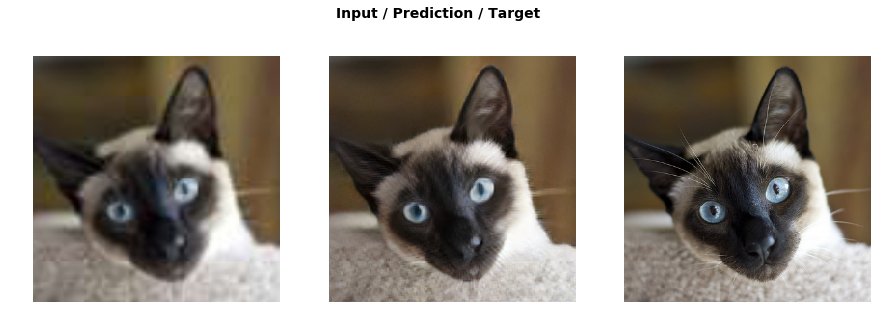

In [ ]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

## Test

In [ ]:
data_mr = (ImageImageList.from_folder(path_mr).random_split_by_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=(819,1024), tfm_y=True)
          .databunch(bs=2).normalize(imagenet_stats, do_y=True))

In [ ]:
learn.data = data_mr

In [ ]:
fn = data_mr.valid_ds.x.items[0]; fn

PosixPath('/data1/jhoward/git/course-v3/nbs/dl1/data/oxford-iiit-pet/small-256/Siamese_178.jpg')

In [ ]:
img = open_image(fn); img.shape

torch.Size([3, 256, 320])

In [ ]:
_,img_hr,b = learn.predict(img)

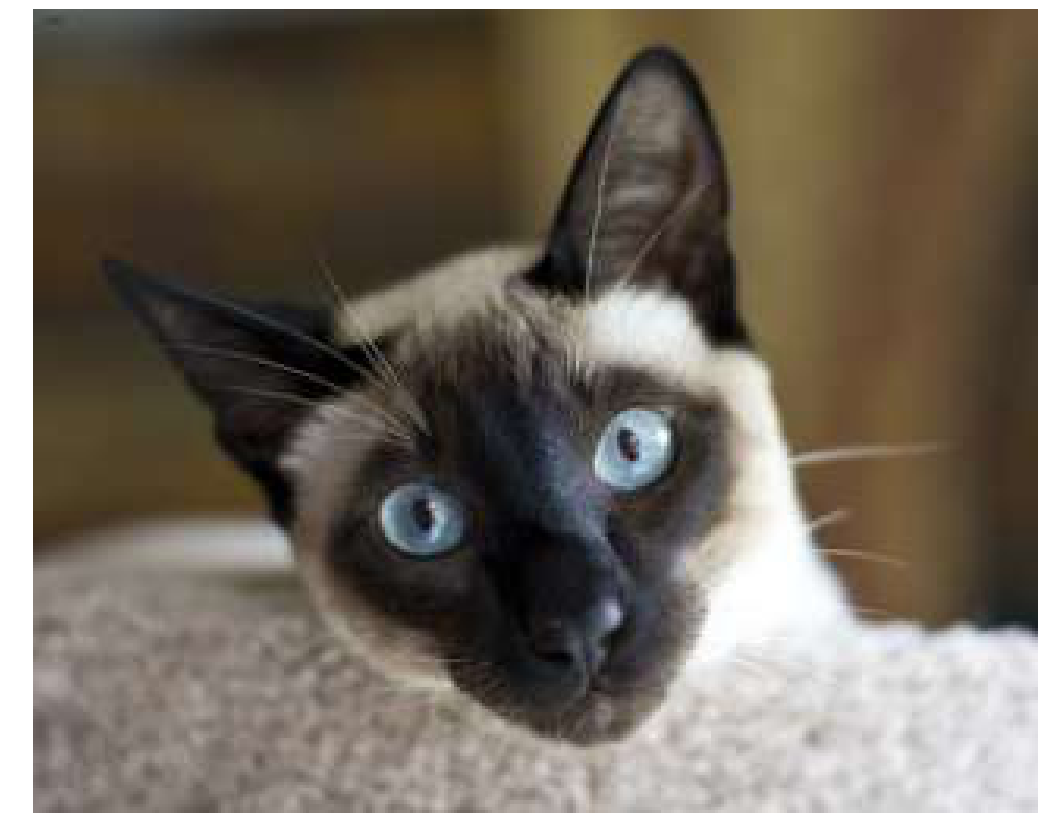

In [ ]:
show_image(img, figsize=(18,15), interpolation='nearest')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


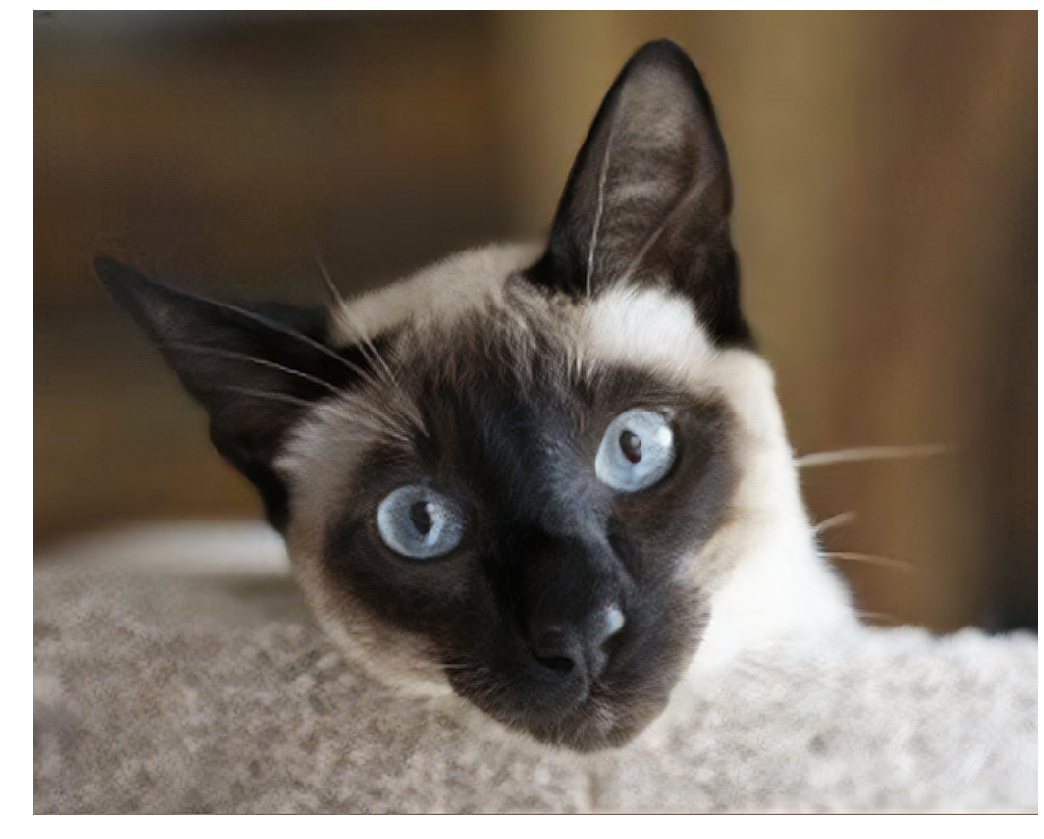

In [ ]:
Image(img_hr).show(figsize=(18,15))